In [1]:
# install evaluate library for computing the metrics during evaluation
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00a 0:00:01


# Import libraries

In [2]:
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from sklearn.metrics import classification_report
import numpy as np
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={"figure.figsize": (12, 6)})

2024-08-22 01:59:50.214893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 01:59:50.215050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 01:59:50.361071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the data

In [3]:
data = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')\
    .drop('Unnamed: 0', axis = 1)
print(f'No of rows: {data.shape[0]} | No of columns: {data.shape[1]}')
data.head()

No of rows: 53043 | No of columns: 2


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# Data Prep

In [4]:
# check if there are missing values
data.isnull().sum()

statement    362
status         0
dtype: int64

In [5]:
# drop rows with missing values
data_prep = data.dropna()
print(f'No of rows: {data_prep.shape[0]}')

No of rows: 52681


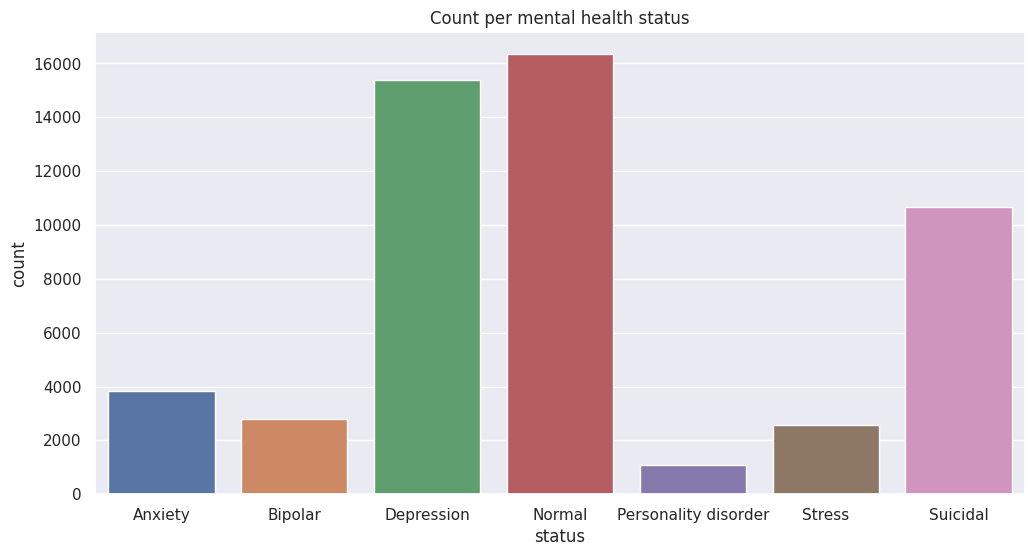

In [6]:
tbl = data_prep.groupby('status').size().to_frame('count').reset_index()
sns.barplot(tbl, x='status', y='count').set_title('Count per mental health status');

Most of the statements are showing normal, depress and suicidal status.

## Check no of tokens per statement

In [7]:
data_prep['tokens'] = data_prep['statement'].apply(lambda x: len(x.split()))
data_prep

,statement,status,tokens
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14
...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,322
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,198
53040,Is there any way to sleep better? I can't slee...,Anxiety,17
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,74


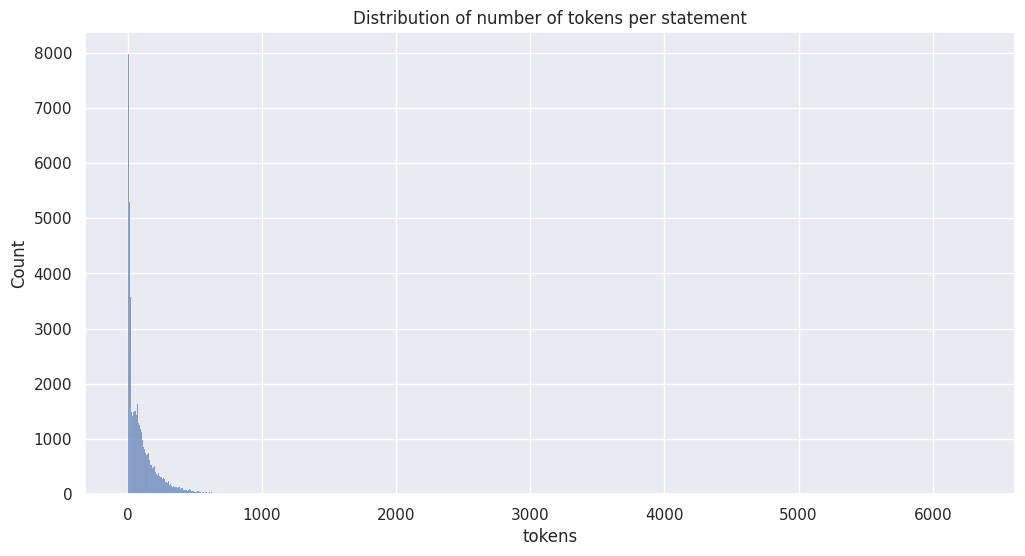

In [8]:
sns.histplot(data_prep, x = 'tokens').set_title('Distribution of number of tokens per statement');

In [9]:
# check the minimum, average, median and max no of tokens
print(f'Min: {data_prep["tokens"].min()}')
print(f'Max: {data_prep["tokens"].max()}')
print(f'Avg: {data_prep["tokens"].mean()}')

Min: 1
Max: 6300
Avg: 113.15872895351265


In [10]:
# check the average number of tokens per status
data_prep.groupby('status').mean('tokens').round(0)

,tokens
status,
Anxiety,144.0
Bipolar,176.0
Depression,168.0
Normal,17.0
Personality disorder,179.0
Stress,115.0
Suicidal,146.0


## Label Encode the data

In [11]:
le = LabelEncoder()
le.fit(data_prep['status'])
data_prep['label'] = le.transform(data_prep['status'])
data_prep

,statement,status,tokens,label
0,oh my gosh,Anxiety,3,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,0
3,I've shifted my focus to something else but I'...,Anxiety,11,0
4,"I'm restless and restless, it's been a month n...",Anxiety,14,0
...,...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,322,0
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,198,0
53040,Is there any way to sleep better? I can't slee...,Anxiety,17,0
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,74,0


# Split the data

In [12]:
data_train, data_test = train_test_split(data_prep, train_size=0.8,stratify=data_prep['label'],
                                     random_state=75)

In [13]:
# train data summary
train_summary = data_train.groupby('status').size().to_frame('count').reset_index()
train_summary['%'] = round(train_summary['count']/train_summary['count'].sum()*100, 2)
train_summary

,status,count,%
0,Anxiety,3073,7.29
1,Bipolar,2221,5.27
2,Depression,12323,29.24
3,Normal,13074,31.02
4,Personality disorder,862,2.05
5,Stress,2070,4.91
6,Suicidal,8521,20.22


## Convert the data to dataset format

In [14]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(data_train),
    'test': Dataset.from_pandas(data_test)
})

In [15]:
dataset['train'][5]

{'statement': 'Tuition and rent due, no money, graduating soon with nothing lined up, the only person I want to talk to ignores me and I am a terrible person because I obsessively stalk their location to know that they are ignoring me. When they talk to me it feels like they are only doing it bc I am going insane. And then I hate them. Even if I had a job lined up and were surrounded by friends I still find life incredibly boring. I do not want to fucking be here anymore I want to die',
 'status': 'Suicidal',
 'tokens': 96,
 'label': 6,
 '__index_level_0__': 12301}

# Tokenize the data

In [16]:
checkpoint = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(data):
    return tokenizer(data['statement'], padding='max_length', truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Train a classifier
Import the pretrained model that will be used

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7,
                                                           problem_type='single_label_classification')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the metrics that will be evaluated during training

In [20]:
def compute_metrics(y_pred_):
    f1_ = evaluate.load('f1')
    accuracy_ = evaluate.load('accuracy')
    logits, labels = y_pred_
    y_pred = np.argmax(logits, axis=-1)
    f1 = f1_.compute(predictions=y_pred, references=labels, average='micro')
    accuracy = accuracy_.compute(predictions=y_pred, references=labels)
    return {'f1': f1, 'accuracy': accuracy}

Provide the training arguments to be used

In [21]:
batch_size = 16
training_args = TrainingArguments('train', num_train_epochs=3, evaluation_strategy='epoch',
                                 learning_rate=5e-5,
                                 per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                 report_to='none')

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.477600,0.422293,{'f1': 0.8269906045363957},{'accuracy': 0.8269906045363956}
2,0.331200,0.428309,{'f1': 0.8360064534497487},{'accuracy': 0.8360064534497486}
3,0.203500,0.477233,{'f1': 0.8424599031982538},{'accuracy': 0.8424599031982538}


TrainOutput(global_step=7902, training_loss=0.3710188009985729, metrics={'train_runtime': 3826.7789, 'train_samples_per_second': 33.039, 'train_steps_per_second': 2.065, 'total_flos': 1.6749611541430272e+16, 'train_loss': 0.3710188009985729, 'epoch': 3.0})

# Model Performance

In [24]:
# classification report
y_pred = trainer.predict(tokenized_datasets['test']).predictions
y_pred = np.argmax(y_pred, axis=-1)
y_true = tokenized_datasets['test']['label']
y_true = np.array(y_true)
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), digits=2))

                      precision    recall  f1-score   support

             Anxiety       0.88      0.89      0.89       768
             Bipolar       0.89      0.90      0.90       556
          Depression       0.81      0.77      0.79      3081
              Normal       0.96      0.96      0.96      3269
Personality disorder       0.81      0.80      0.80       215
              Stress       0.75      0.80      0.77       517
            Suicidal       0.72      0.76      0.74      2131

            accuracy                           0.84     10537
           macro avg       0.83      0.84      0.83     10537
        weighted avg       0.84      0.84      0.84     10537

